# Comparing OLS and KNN regression models with Abalone dataset

I will be using a dataset created with measurements of Abalone designed to predict the age of the Abalone. The process of discovering the age of Abalone is an arduous task of drilling through the core of the shell and counting the rings in the shell through a microscope. The rings in the data is a stand-in for age. I will be creating an OLS regression model and a KNN regression model that both attempt to predict the rings (age) of the abalone, and comparing for overall performance. I will then choose the best model. This model can be beneficial to scientists in determining abalone specimen age with much easier measurements to obtain.

In [28]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn

In [58]:
df = pd.read_csv('abalone.csv')
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [59]:
# Change Sex to a numerical categorical variable, where 1 = Male, 0 = Female
df.Sex = np.where(df['Sex'] == 'M', 1, 0)
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [61]:
df.describe()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.365813,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.481715,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,1.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,1.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


All of the counts are equal, so I don't have to worry about any NaN values or other data cleaning issues.

c:\users\ross last\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


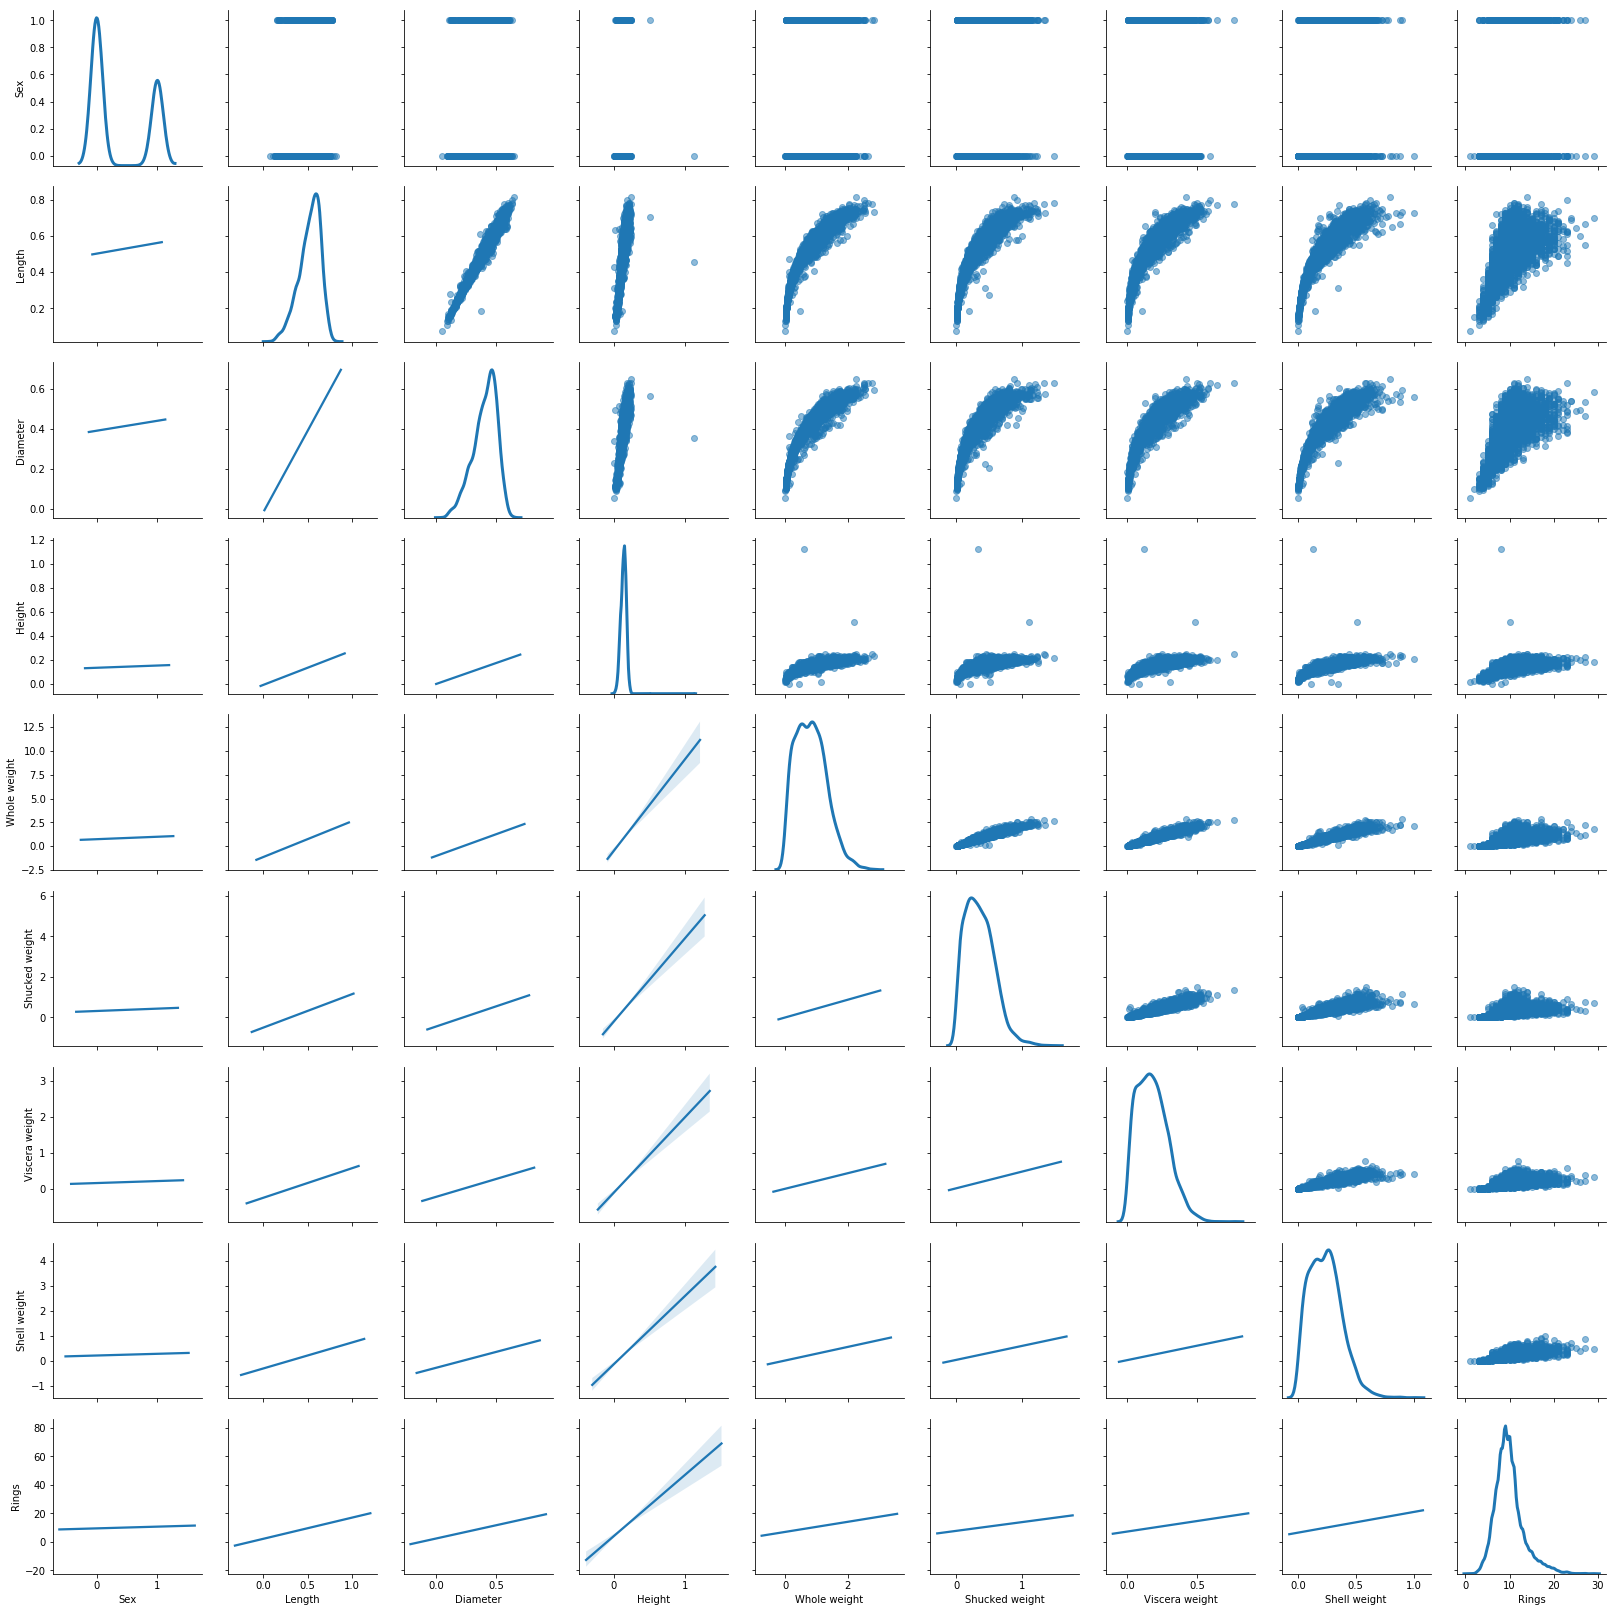

In [62]:
g = sns.PairGrid(df, diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

Nothing seems out of the ordinary here so far. I will create a correlation matrix and a corresponding heatmap to assess which variables are correlated.

                     Sex    Length  Diameter    Height  Whole weight  \
Sex             1.000000  0.236543  0.240376  0.215459      0.252038   
Length          0.236543  1.000000  0.986812  0.827554      0.925261   
Diameter        0.240376  0.986812  1.000000  0.833684      0.925452   
Height          0.215459  0.827554  0.833684  1.000000      0.819221   
Whole weight    0.252038  0.925261  0.925452  0.819221      1.000000   
Shucked weight  0.251793  0.897914  0.893162  0.774972      0.969405   
Viscera weight  0.242194  0.903018  0.899724  0.798319      0.966375   
Shell weight    0.235391  0.897706  0.905330  0.817338      0.955355   
Rings           0.181831  0.556720  0.574660  0.557467      0.540390   

                Shucked weight  Viscera weight  Shell weight     Rings  
Sex                   0.251793        0.242194      0.235391  0.181831  
Length                0.897914        0.903018      0.897706  0.556720  
Diameter              0.893162        0.899724      0.905330

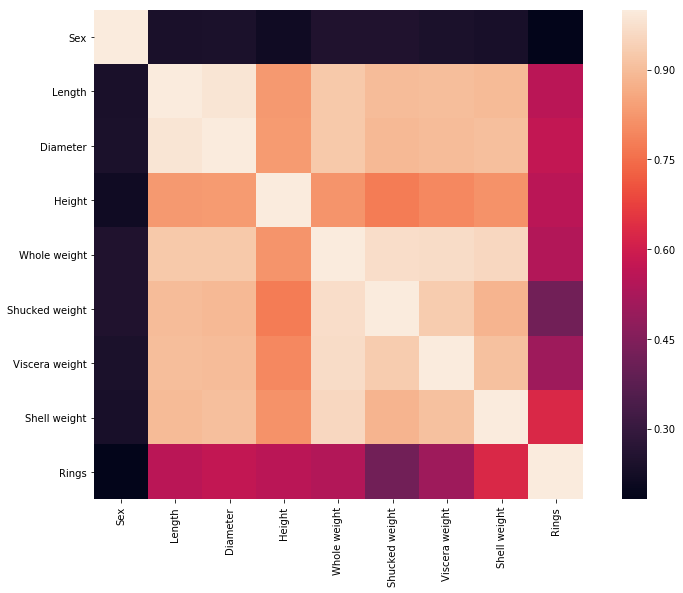

In [63]:
corrmat = df.corr()

print(corrmat)

f, ax = plt.subplots(figsize=(14, 9))

sns.heatmap(corrmat, square=True)
plt.show()

So my target, Rings, is not as correlated to any of the variables specifically as they all are to each other (except for Sex, which is a categorical variable that I will ignore for this correlation matrix). I will normalize the data first and run PCA on two groups of variables that have the highest correlation, choosing an amount of features that explain the most variance. I will also create a feature running PCA on all 7 continuous variables variables that I will have in case of need.

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)

df_pca_1 = df[['Length', 'Diameter']]

X_1 = StandardScaler().fit_transform(df_pca_1)
Y_1 = pca.fit_transform(X_1)

print(
    'The percentage of total variance in the first data group explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)

df_pca_2 = df[['Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']]

X_2 = StandardScaler().fit_transform(df_pca_2)
Y_2 = pca.fit_transform(X_2)

print(
    'The percentage of total variance in the second data group explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)

The percentage of total variance in the first data group explained by each component from Sklearn PCA.
 [0.99340579 0.00659421]
The percentage of total variance in the second data group explained by each component from Sklearn PCA.
 [0.95185916 0.03025617]


The first feature for each set created explains over 90% of the variance. The rest are almost none of the variance explained, so I will clearly only keep the first feature for each set.

In [66]:
# Take the first PCA feature into the data
df['feature_1'] = Y_1[:, 0]
df['feature_2'] = Y_2[:, 0]

In [71]:
from sklearn import linear_model

regr = linear_model.LinearRegression()

X = df[['feature_1', 'feature_2', 'Height']]
y = df.Rings.values.reshape(-1, 1)

regr.fit(X, y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, y))


Coefficients: 
 [[-0.8499494  -0.08901197  0.30560262 21.75607127]]

Intercept: 
 [6.78656239]

R-squared:
0.34768619579865667


So far, this is not good. Perhaps the KNN model will run with these features better. Let's turn our attention to building this.

In [74]:
from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X, y).score(X, y)

1.0

That is an unusually high $R^2$ value. I'm worried of overfitting, so I will do some cross validation

In [82]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score

Accuracy: 0.09 (+/- 0.53)


array([ 0.11836707, -0.4301615 ,  0.27856982,  0.2598903 ,  0.23466851])

As I worried, it does not perform well with cross validation. But perhaps I can workshop this and reduce the amount of features to combat overfitting. At least the model performed well at first. I will remove features one at a time to check for performance of this model.

In [84]:
X = df[['feature_1', 'feature_2']]
y = df.Rings.values.reshape(-1, 1)

from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score

Accuracy: 0.03 (+/- 0.64)


array([ 0.10398665, -0.60036247,  0.2604301 ,  0.20051082,  0.19976106])

In [103]:
knn = neighbors.KNeighborsRegressor(n_neighbors=1000)

X = df[['feature_1']]
y = df.Rings

score = cross_val_score(knn, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score

Accuracy: 0.06 (+/- 0.45)


array([ 0.25314199,  0.03186564, -0.25723322, -0.27620213,  0.21866005,
        0.11905463, -0.27651996,  0.251325  ,  0.22284387,  0.29442617])

Based on the dataset that I used and the features that I was able to pull out, I would assess the KNN regression to be the better model for this situation. Neither performs all that well in the end. But the KNN regression was at least able to perform well on the training data, then struggle to perform well in validation testing. The OLS regression did not even perform well on the training data, with a very low $R^2$. 

I would ascribe the differences between these two models with this particular dataset to the nature of the relationships between the data. The independent variables had high multicollinearity, but none had particularly great linear relationship to the dependen variable, the rings/age of the abalone. Finding linear relationships then is hard to the OLS, but with the KNN it could at least try to judge by what data is close. This didn't translate to test data, but it is at least a start to finding something that could work.

With more time and knowledge, I would improve these models with better feature engineering to try to pull out what features can build successful models. Perhaps this data though simply isn't fit for the types of models for this assignment and would be better served in a different model asssignment.